### CSV files used:

`csv_files/Gun_Violence_Data.csv`  
downloaded from *[here](https://www.kaggle.com/jameslko/gun-violence-data)*

`csv_files/State_Firearm_Law_Database.csv`  
downloaded from *[here](https://www.rand.org/pubs/tools/TL283.html)* (Base file is in .xlsx format)  
To view the cleaned-up version, follow this *[link to the Google Sheets Doc](https://docs.google.com/spreadsheets/d/1hGbucoI2RCAdkdSI7C4GYLoGaSansGANfqxXobpIrog/edit?usp=sharing)*)

In [12]:
# run this cell first to create database

import pandas as pd

gun_violence_df = pd.read_csv('csv_files/Gun_Violence_Data.csv')
gun_violence_df.to_sql("Gun_Violence_Data", sqlite3.connect("gun_crime_and_state_laws_2.db"), if_exists = "replace")

gun_laws_df = pd.read_csv('csv_files/State_Firearm_Law_Database.csv', na_filter=False)
gun_laws_df.to_sql("State_Firearm_Law_Database", sqlite3.connect("gun_crime_and_state_laws_2.db"), if_exists = "replace")

## QUESTION:

***Is there a relationship between the amount of gun-related crime and the strictness of laws  
(measuring for each state)?***  
***In other words, how effective are gun laws?***

In [2]:
# run this cell second to set up functions and import statements used in other cells

import sqlite3
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set(color_codes=True)


def get_states():
    conn = sqlite3.connect('gun_crime_and_state_laws_2.db')
    return list(
        conn.execute('''
            SELECT DISTINCT State FROM 'State_Firearm_Law_Database'; 
        ''')
    )
    conn.close()
    
def get_types_of_laws():
    conn = sqlite3.connect('gun_crime_and_state_laws_2.db')
    return conn.execute('''
        SELECT DISTINCT TypeofLaw FROM 'State_Firearm_Law_Database'; 
    ''')
    conn.close()
    
def get_laws_by_type_change(type_of_change):
    conn = sqlite3.connect('gun_crime_and_state_laws_2.db')
    return list(
        conn.execute('''
            SELECT State, TypeofLaw, Effect, TypeofChange, EffectiveDate, Content, CaveatsandAmbiguities
                FROM 'State_Firearm_Law_Database'
                WHERE TypeofChange = ?
                GROUP BY TypeofLaw, State
                ORDER BY State;
        ''', (type_of_change,))
    )
    conn.close()

def get_laws_by_state():
    conn = sqlite3.connect('gun_crime_and_state_laws_2.db')
    return list(
        conn.execute('''
            SELECT State, TypeofLaw, Effect, TypeofChange, EffectiveDate, Content, CaveatsandAmbiguities
            FROM 'State_Firearm_Law_Database'
            GROUP BY TypeofLaw, State
            ORDER BY State, TypeofChange;
        ''')
    )
    conn.close()

def count_laws_by_effect():
    conn = sqlite3.connect('gun_crime_and_state_laws_2.db')
    return conn.execute('''
        SELECT l.State, p.Count AS PermissiveCount, r.Count AS RestrictiveCount, n.Count AS NeutralCount 
            FROM State_Firearm_Law_Database AS l
            INNER JOIN(
                SELECT State, COUNT(*) as Count from State_Firearm_Law_Database WHERE Effect = 'Permissive' GROUP BY State
            ) as p ON l.State = p.State
            INNER JOIN(
                SELECT State, COUNT(*) as Count from State_Firearm_Law_Database WHERE Effect = 'Restrictive' GROUP BY State
            ) as r ON l.State = r.State
            INNER JOIN(
                SELECT State, COUNT(*) as Count from State_Firearm_Law_Database WHERE Effect = 'N/A' GROUP BY State
            ) as n ON l.State = n.State
            GROUP BY l.State;
    ''')
    conn.close()
    
def get_top_ten_for_totalincidents():
    conn = sqlite3.connect('gun_crime_and_state_laws_2.db')
    return conn.execute('''
        SELECT state, COUNT(*) AS Num_Incidents FROM 'Gun_Violence_Data'
            WHERE date NOT LIKE '2013%' AND date NOT LIKE '2018%'
            GROUP BY state ORDER BY Num_Incidents DESC LIMIT 10;
    ''')
    conn.close()
    
# clean up
def format_laws(states, laws, printAll=False):
    for state in states:
        if state[0]:
            list_of_laws = []
            for law in laws:
                if state[0] == law[0]:
                    list_of_laws.append([law[1], law[2], law[3], law[4], law[5], law[6]])
            if len(list_of_laws) > 0:
                print()
                print('\t' + state[0].upper() + ':')
                print()
                for law in list_of_laws:
                    print('\tType of Law: ' + law[0])
                    print('\tEffect: ' + law[1])
                    if printAll:
                        print('\tType of Change: ' + law[2])
                    else:
                        pass
                    print('\tEffective Date: ' + law[3])
                    if law[4]:
                        print('\tContent: ' + law[4])
                    else:
                        pass
                    if law[5]:
                        print('\tCaveats and Ambiguities: ' + law[5])
                    else:
                        pass
                    print()            
                print('\tNumber of Laws: ' + str(len(list_of_laws)))
                print()
                print('\t*****')
        else:
            pass

### Some Preliminary Questions

***What are the different types of laws concerning guns?***

In [14]:
laws = get_types_of_laws()

counter = 1
for law in laws:
    if law[0]:
        print(str(counter) + '. ' + law[0])
        counter += 1
    else:
        pass

1. Background checks for sales from dealers - handguns and long guns
2. Castle Doctrine
3. Castle Doctrine - Stand Your Ground
4. Child access law
5. Carrying a concealed weapon (CCW) - shall issue
6. Dealer license - handguns
7. Dealer license - long guns
8. Minimum age for youth possession - handguns and long guns
9. Minimum age for youth possession - long guns
10. Minimum purchase and sale age - handguns
11. One gun per month - handguns
12. Open Carry permitted
13. Registration - handguns
14. Registration - long guns
15. Waiting period - handguns
16. Background Checks for private sales - handguns and long guns
17. Carrying a concealed weapon (CCW) - prohibited
18. Carrying a concealed weapon (CCW) - shall issue (permit not required)
19. Dealer license - handguns and long guns
20. Minimum purchase and sale age - handguns and long guns
21. Registration - handguns and long guns
22. Background checks for sales from dealers - handguns
23. Background checks for sales from dealers - long g

### How have laws changed over the years?

***What/how many laws have been repealed in each state?***

In [15]:
repealedLaws = get_laws_by_type_change('Repeal')
states = get_states()

print('REPEALED LAWS:')
print()
format_laws(states, repealedLaws)

REPEALED LAWS:


	ALABAMA:

	Type of Law: Registration - handguns
	Effect: Permissive
	Effective Date: 9/1/2015
	Content: (b) All records of pistol, revolver, or maxim silencer sales that are maintained or in the custody of dealers, the chief
of police, the sheriff, or the Secretary of State pursuant to this section or Section 40-12-143, including any records or
databases compiled as a result of or based on the records or information so maintained or received, shall be permanently
removed and destroyed without reproduction of the removed documents no later than February 28, 2016. This section
does not apply to any record necessary for an active investigation or ongoing prosecution.

	Type of Law: Waiting period - handguns
	Effect: Permissive
	Effective Date: 8/1/2000
	Content: Repealed.

	Number of Laws: 2

	*****

	COLORADO:

	Type of Law: Background checks for sales from dealers - handguns
	Effect: Permissive
	Effective Date: 2/28/1999
	Content: 12-26.5-109.  Repeal of article
This a

***What/how many laws have been implemented in each state?***

In [16]:
implementedLaws = get_laws_by_type_change('Implement')
states = get_states()

print('IMPLEMENTED LAWS:')
print()
format_laws(states, implementedLaws)

IMPLEMENTED LAWS:


	ALABAMA:

	Type of Law: Castle Doctrine
	Effect: Permissive
	Effective Date: 5/16/1978
	Content: A person may use deadly physical force under the circumstances set forth in subsection (1) of this section only: (a) In defense of a person a provided in § 610 of this chapter (Justification: Use of Force in Defense of a Person): or (b) When he reasonably believes it is necessary to prevent the commission of arson in the first or second degree by the trespasser

	Type of Law: Dealer license - handguns
	Effect: Restrictive
	Effective Date: 9/11/1951
	Content: Section 1. That Article 2, Chapter 40, of Title 14 of the 1940 Code of Alabama, be and the same is hereby amended to read as follows: [...] Section 180. Dealers to be licensed. -- No retail dealer shall sell or otherwise transfer, or expose for sale or transfer, or have in his possession with intent to sell, or otherwise transfer, any pistol without being licensed and hereinafter provided. Section 181. Dealer's lice

	Type of Law: Background checks for sales from dealers - handguns and long guns
	Effect: Restrictive
	Effective Date: 11/1/1989
	Content: B.1. No dealer shall sell, rent, trade or transfer from his inventory any such firearm to any other person who is a resident of Virginia until he has (i) obtained written consent as specified in subsection A, and provided the Department of State Police with the name, birth date, gender, race, and social security and/or any other identification number and (iii) requested and received criminal history record information by a telephone call to the State
Police.  
G. "Firearm" means any (i) handgun or pistol having a barrel length of less than five inches which expels a projectile by action of an explosion or (ii) semi-automatic center-fire rifle or pistol which expels a projectile by action of an explosion and is provided by the manufacturer with a magazine which will hold more than twenty rounds of ammunition or designed by the manufacturer to accommod

***What/how many laws have been modified in each state?***

In [17]:
modifiedLaws = get_laws_by_type_change('Modify')
states = get_states()

print('MODIFIED LAWS:')
print()
format_laws(states, modifiedLaws)

conn.close()

MODIFIED LAWS:


	ALABAMA:

	Type of Law: Carrying a concealed weapon (CCW) - shall issue
	Effect: Permissive
	Effective Date: 5/28/1905
	Content: The sheriff of a county, upon the application of any person residing in that county, within 30 days from receipt of a complete application and accompanying fee, shall issue or renew a permit for such person to carry a pistol in a vehicle or concealed on or about his or her person within this state for one to five year increments, as requested by the person seeking the permit, from date of issue, unless the sheriff determines that the person is prohibited from the possession of a pistol or firearm pursuant to state or federal law, or has a reasonable suspicion that the person may use a weapon unlawfully or in such other manner that would endanger the person's self or others. [goes on to list what sheriff may consider]

	Type of Law: Castle Doctrine - Stand Your Ground
	Effect: Permissive
	Effective Date: 6/1/2006
	Content: A person who is jus

***Of the modified laws, were they made to be more restrictive or more permissive?***

In [18]:
modifiedLaws = get_laws_by_type_change('Modify')
states = get_states()

# print(modifiedLaws)

permissive_laws = []
restrictive_laws = []
other_laws = 0

print('OF LAWS THAT WERE MODIFIED:')
print()

for state in states:
    if state[0]:
        permissive_laws = []
        restrictive_laws = []
        other_laws = 0
        for law in modifiedLaws:
            if state[0] == law[0]:
                if law[2] == 'Permissive':
                    permissive_laws.append(law)
                elif law[2] == 'Restrictive':
                    restrictive_laws.append(law)
                else:
                    other_laws += 1
        if len(permissive_laws) > 0 or len(restrictive_laws) > 0:
            print('\t IN ' + state[0].upper() + ':')
            print()
            if len(permissive_laws) > 0:
                if len(permissive_laws) == 1:
                    verb_number = ' WAS'
                elif len(permissive_laws) > 1:
                    verb_number = ' WERE'
                print('\t\t' + str(len(permissive_laws)) + verb_number + ' MADE (OR ALREADY' + verb_number + ') MORE PERMISSIVE:')
                for law in permissive_laws:
                    print('\t\t\tType of Law: ' + law[1])
                print()
            else:
                pass
            if len(restrictive_laws) > 0:
                if len(restrictive_laws) == 1:
                    verb_number = ' WAS'
                elif len(restrictive_laws) > 1:
                    verb_number = ' WERE'
                print('\t\t' + str(len(restrictive_laws)) + verb_number + ' MADE (OR ALREADY' + verb_number + ') MORE RESTRICTIVE:')
                for law in restrictive_laws:
                    print('\t\t\tType of Law: ' + law[1])
                print()
            else:
                pass
            if other_laws > 0:
                print('\t\t\tNumber of Neutral Laws: ' + str(other_laws))
    else:
        pass

OF LAWS THAT WERE MODIFIED:

	 IN ALABAMA:

		2 WERE MADE (OR ALREADY WERE) MORE PERMISSIVE:
			Type of Law: Carrying a concealed weapon (CCW) - shall issue
			Type of Law: Castle Doctrine - Stand Your Ground

	 IN ALASKA:

		3 WERE MADE (OR ALREADY WERE) MORE PERMISSIVE:
			Type of Law: Carrying a concealed weapon (CCW) - shall issue
			Type of Law: Carrying a concealed weapon (CCW) - shall issue (permit not required)
			Type of Law: Castle Doctrine - Stand Your Ground

	 IN ARIZONA:

		2 WERE MADE (OR ALREADY WERE) MORE PERMISSIVE:
			Type of Law: Carrying a concealed weapon (CCW) - shall issue (permit not required)
			Type of Law: Castle Doctrine - Stand Your Ground

	 IN ARKANSAS:

		1 WAS MADE (OR ALREADY WAS) MORE PERMISSIVE:
			Type of Law: Carrying a concealed weapon (CCW) - shall issue

	 IN CALIFORNIA:

		9 WERE MADE (OR ALREADY WERE) MORE RESTRICTIVE:
			Type of Law: Background checks for sales from dealers - handguns and long guns
			Type of Law: Child access laws - neglige

***What/how many other laws (no change) are there in each state?***

In [19]:
otherLaws = get_laws_by_type_change('N/A')
states = get_states()

print('OTHER LAWS:')
print()
format_laws(states, otherLaws)

OTHER LAWS:


	ALABAMA:

	Type of Law: Background Checks for private sales - handguns and long guns
	Effect: N/A
	Effective Date: N/A
	Content: No law requiring background checks for private sales of handguns or long guns

	Type of Law: Background checks for sales from dealers - handguns and long guns
	Effect: N/A
	Effective Date: N/A
	Content: No law requiring background checks for sales from dealers of handguns or long guns

	Type of Law: Child access law
	Effect: N/A
	Effective Date: N/A
	Content: No CAP law

	Type of Law: Dealer license - long guns
	Effect: N/A
	Effective Date: N/A
	Content: No law requiring dealer license for long guns

	Type of Law: Minimum age for youth possession - handguns and long guns
	Effect: N/A
	Effective Date: N/A
	Content: No law imposing minimum age for youth possession of handguns or long guns

	Type of Law: Minimum age for youth possession - long guns
	Effect: N/A
	Effective Date: N/A
	Content: No law imposing minimum purchase and sale age for long g

	Effect: N/A
	Effective Date: N/A
	Content: No law requiring background checks for private sales of handguns or long guns

	Type of Law: Background checks for sales from dealers - handguns and long guns
	Effect: N/A
	Effective Date: N/A
	Content: No law requiring background checks for sales from dealers of handguns or long guns

	Type of Law: Castle Doctrine
	Effect: N/A
	Effective Date: N/A
	Content: Common Law Castle Doctrine

	Type of Law: Child access law
	Effect: N/A
	Effective Date: N/A
	Content: No CAP law

	Type of Law: Child access prevention (CAP) law
	Effect: N/A
	Effective Date: N/A
	Content: No CAP law

	Type of Law: Dealer license - long guns
	Effect: N/A
	Effective Date: N/A
	Content: No law requiring dealer license for long guns

	Number of Laws: 6

	*****

	SOUTH DAKOTA:

	Type of Law: Background Checks for private sales - handguns and long guns
	Effect: N/A
	Effective Date: N/A
	Content: No law requiring background checks for private sales of handguns or long guns

	T

### Plot Laws by Effect for Top Ten States for Gun Violence (2014-2017)

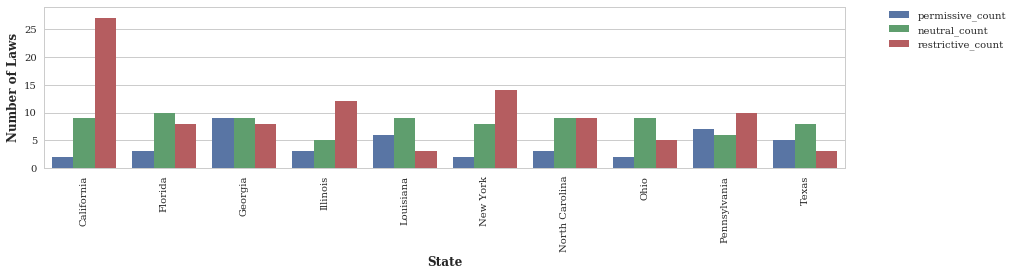

In [13]:
# get number of laws by the effect of the law (Restrictive, Permissive, or Neutral)
cursor_laws = count_laws_by_effect()
rows_laws = cursor_laws.fetchall()

# get top ten states for gun violence according to total incidents in the database
# (omitting 2013 and 2018 for incomplete data)
cursor_incidents = get_top_ten_for_totalincidents()
rows_incidents = cursor_incidents.fetchall()

top_states = list(map(lambda x: x[0], rows_incidents))

# get laws for top ten states for gun violence
laws_for_top_states = []

for state in top_states:
    for law in rows_laws:
        if law[0] == state:
            laws_for_top_states.append(law)
        else:
            pass
            
all_states = list(map(lambda x: x[0], laws_for_top_states))
permissive = list(map(lambda x: x[1], laws_for_top_states))
restrictive = list(map(lambda x: x[2], laws_for_top_states))
neutral = list(map(lambda x: x[3], laws_for_top_states))

# prepare the pandas dataframe
effects_data = {'state': top_states, 'permissive_count': permissive, 'restrictive_count': restrictive, 'neutral_count': neutral}
effects_df = pd.DataFrame.from_dict(effects_data)
effects_df = pd.melt(effects_df, id_vars=['state'], value_vars=['permissive_count', 'restrictive_count', 'neutral_count']).sort_values(['state'])

# ======= FIGURE SETTINGS ========

sns.set(style="whitegrid")
sns.axes_style({'legend.frameon': True})
# flatui = ["red", "green", "blue"]
# current_palette = sns.color_palette()
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold'

# ======= PLOT FIGURE ================

plt.figure(figsize=(12, 4))

ax = sns.barplot(x="state", y="value", hue="variable", data=effects_df)
ax.set(xlabel='State', ylabel='Number of Laws', ylim=[0, 29])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


## DATA CLEANUP AND RE-ORGANIZATION

In order to gather the data needed into one database, I needed to separate it by state.  
In the following code and queries, the laws are separated by state and the incidents are separated by state.  
Then, incidents are counted and averaged by year, laws are tallyed as permissive or restrictive, and the resulting data  
is entered in a new table.

In [21]:

# =======================================
# create tables for each state's gun laws
# =======================================

# get data
allLaws = get_laws_by_state()
states = get_states()

conn = sqlite3.connect('gun_crime_and_state_laws_2.db')

# create database for each state
for state in states:
    state_to_upper = state[0].upper().replace(" ", "")
    table_name = '{}_LAWS'.format(state_to_upper)
    
    conn.execute('''
        DROP TABLE IF EXISTS {tn};    
    '''.format(tn=table_name))
    
    # if row is not empty
    if state[0]:
        conn.execute('''
            CREATE TABLE IF NOT EXISTS {tn} (
                Id INTEGER PRIMARY KEY AUTOINCREMENT,
                TypeofLaw VARCHAR(255),
                Effect VARCHAR(255),
                TypeofChange VARCHAR(255),
                EffectiveDate VARCHAR(255),
                Content VARCHAR(500),
                CaveatsandAmbiguities VARCHAR(500)
            );
        '''.format(tn=table_name))
    
    for law in allLaws:
        # if row is not empty
        if state[0]:
            # find all of the laws for this specific state
            if state[0] == law[0]:
                conn.execute('''
                    INSERT INTO {tn} (
                        TypeofLaw, 
                        Effect, 
                        TypeofChange, 
                        EffectiveDate, 
                        Content, 
                        CaveatsandAmbiguities
                    )
                    VALUES (
                        ?, 
                        ?, 
                        ?, 
                        ?, 
                        ?, 
                        ?
                    );
                '''.format(tn=table_name), (law[1], law[2], law[3], law[4], law[5], law[6]))
                conn.commit()

conn.close()

In [23]:
# NOTE: This script can take some time to complete because of the size of the dataset.

# =====================================================
# create tables for each state's gun violence incidents
# =====================================================

# get data
states = get_states()

conn = sqlite3.connect('gun_crime_and_state_laws_2.db')

# (omits data for 2013 and 2018 because the data for those years is incomplete)
allIncidents = list(
    conn.execute('''
        SELECT 
            date, 
            state, 
            n_killed,
            n_injured
        FROM 'Gun_Violence_Data'
        WHERE date NOT LIKE '2013%' AND
        date NOT LIKE '2018%'
        ORDER BY state, date;
    ''')
)

# create database for each state
for state in states:
    state_to_upper = state[0].upper().replace(" ", "")
    table_name = '{}_INCIDENTS'.format(state_to_upper)
    
    conn.execute('''
        DROP TABLE IF EXISTS {tn};    
    '''.format(tn=table_name))
    
    # if row is not empty
    if state[0]:
        conn.execute('''
            CREATE TABLE IF NOT EXISTS {tn} (
                Id INTEGER PRIMARY KEY AUTOINCREMENT,
                Date DATETIME DEFAULT NULL,
                State VARCHAR(255),
                N_Killed INTEGER,
                N_Injured INTEGER
            );
        '''.format(tn=table_name))
    
    for incident in allIncidents:
        # if row is not empty
        if state[0]:
            # find all of the laws for this specific state
            if state[0] == incident[1]:
                conn.execute('''
                    INSERT INTO {tn} (
                        Date,
                        State,
                        N_Killed,
                        N_Injured
                    )
                    VALUES ( 
                        ?,
                        ?,
                        ?,
                        ?
                    );
                '''.format(tn=table_name), (
                    incident[0],
                    incident[1],
                    incident[2],
                    incident[3],
                    )
                )
                conn.commit()

conn.close()

**In the following queries, each state is scored by how restrictive its gun laws are  
by totalling the laws labeled 'permissive' in the database and subtracting them from  
those labeled 'restrictive'**

In [24]:

# ================================================
# score each state for permissive/restrictive laws
# ================================================

# get data
states = get_states()

conn = sqlite3.connect('gun_crime_and_state_laws_2.db')

# Create new table, State_Laws_Vs_Incidents, to hold data

conn.execute('''
    DROP TABLE IF EXISTS State_Laws_Vs_Incidents
''')

conn.execute('''
    CREATE TABLE State_Laws_Vs_Incidents (
        Id INTEGER PRIMARY KEY AUTOINCREMENT,
        State VARCHAR(255),
        Total_Num_Incidents INTEGER,
        Total_Num_Killed INTEGER,
        Total_Num_Injured INTEGER,
        Average_Incidents_Per_Year INTEGER,
        Average_Killed_Per_Year INTEGER,
        Average_Injured_Per_Year INTEGER,
        Incidents_2014 INTEGER,
        Killed_2014 INTEGER,
        Injured_2014 INTEGER,
        Incidents_2015 INTEGER,
        Killed_2015 INTEGER,
        Injured_2015 INTEGER,
        Incidents_2016 INTEGER,
        Killed_2016 INTEGER,
        Injured_2016 INTEGER,
        Incidents_2017 INTEGER,
        Killed_2017 INTEGER,
        Injured_2017 INTEGER,
        Total_Num_Laws INTEGER,
        Law_Strictness INTEGER
    )
''')

# Gather data and populate State_Laws_Vs_Incidents table

for state in states:
    state_law_database = '{}_LAWS'.format(state[0].upper().replace(" ", ""))
    state_incident_database = '{}_INCIDENTS'.format(state[0].upper().replace(" ", ""))
    
    # Gather data from each state database for laws and state database for incidents
    state_laws = conn.execute('''
        SELECT 
            COUNT(*) AS total_num_incidents,
            SUM(n_killed) AS total_num_killed,
            SUM(n_injured) AS total_num_injured,
            (four.Num_of_Incidents + fif.Num_of_Incidents + six.Num_of_Incidents + seven.Num_of_Incidents) / 4 AS Average_Incidents_Per_Year,
            (four.Num_Killed + fif.Num_Killed + six.Num_Killed + seven.Num_Killed) / 4 AS Average_Killed_Per_Year,
            (four.Num_Injured + fif.Num_Injured + six.Num_Injured + seven.Num_Injured) / 4 AS Average_Injured_Per_Year,
            four.Num_of_Incidents AS Num_Incidents_14,
            four.Num_Killed AS Killed_14,
            four.Num_Injured AS Injured_14,
            fif.Num_of_Incidents AS Num_Incidents_15,
            fif.Num_Killed AS Killed_15,
            fif.Num_Injured AS Injured_15,
            six.Num_of_Incidents AS Num_Incidents_16,
            six.Num_Killed AS Killed_16,
            six.Num_Injured AS Injured_16,
            seven.Num_of_Incidents AS Num_Incidents_17,
            seven.Num_Killed AS Killed_17,
            seven.Num_Injured AS Injured_17,
            t.num_laws AS total_num_laws,
            r.num - p.num AS law_strictness
            FROM {ind} AS i
            INNER JOIN (
                SELECT date, SUM(n_killed) AS Num_Killed, SUM(n_injured) AS Num_Injured, COUNT(*) AS Num_of_Incidents FROM {ind}
                WHERE date LIKE '2014%' 
            ) AS four
            INNER JOIN (
                SELECT date, SUM(n_killed) AS Num_Killed, SUM(n_injured) AS Num_Injured, COUNT(*) AS Num_of_Incidents FROM {ind}
                WHERE date LIKE '2015%' 
            ) AS fif
            INNER JOIN (
                SELECT date, SUM(n_killed) AS Num_Killed, SUM(n_injured) AS Num_Injured, COUNT(*) AS Num_of_Incidents FROM {ind}
                WHERE date LIKE '2016%' 
            ) AS six
            INNER JOIN (
                SELECT date, SUM(n_killed) AS Num_Killed, SUM(n_injured) AS Num_Injured, COUNT(*) AS Num_of_Incidents FROM {ind}
                WHERE date LIKE '2017%' 
            ) AS seven
            INNER JOIN (
                SELECT COUNT(*) AS num FROM {ld} WHERE Effect='Permissive'
            ) AS p
            INNER JOIN (
                SELECT COUNT(*) AS num FROM {ld} WHERE Effect='Restrictive'
            ) AS r
            INNER JOIN (
            SELECT COUNT(*) AS num_laws FROM {ld}
            ) AS t
    '''.format(ind=state_incident_database, ld=state_law_database))
    
    # Insert gathered data into State_Laws_Vs_Incidents table
    for law in state_laws:
        conn.execute('''
            INSERT INTO State_Laws_Vs_Incidents (
                State,
                Total_Num_Incidents,
                Total_Num_Killed,
                Total_Num_Injured,
                Average_Incidents_Per_Year,
                Average_Killed_Per_Year,
                Average_Injured_Per_Year,
                Incidents_2014,
                Killed_2014,
                Injured_2014,
                Incidents_2015,
                Killed_2015,
                Injured_2015,
                Incidents_2016,
                Killed_2016,
                Injured_2016,
                Incidents_2017,
                Killed_2017,
                Injured_2017,
                Total_Num_Laws,
                Law_Strictness
            ) VALUES (
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?,
                ?
            )
        ''', (
            state[0], 
            law[0], 
            law[1], 
            law[2], 
            law[3], 
            law[4], 
            law[5], 
            law[6], 
            law[7], 
            law[8], 
            law[9], 
            law[10],
            law[11],
            law[12],
            law[13],
            law[14],
            law[15],
            law[16],
            law[17],
            law[18],
            law[19]
        ))
        conn.commit()

conn.close()

### Plotting Results

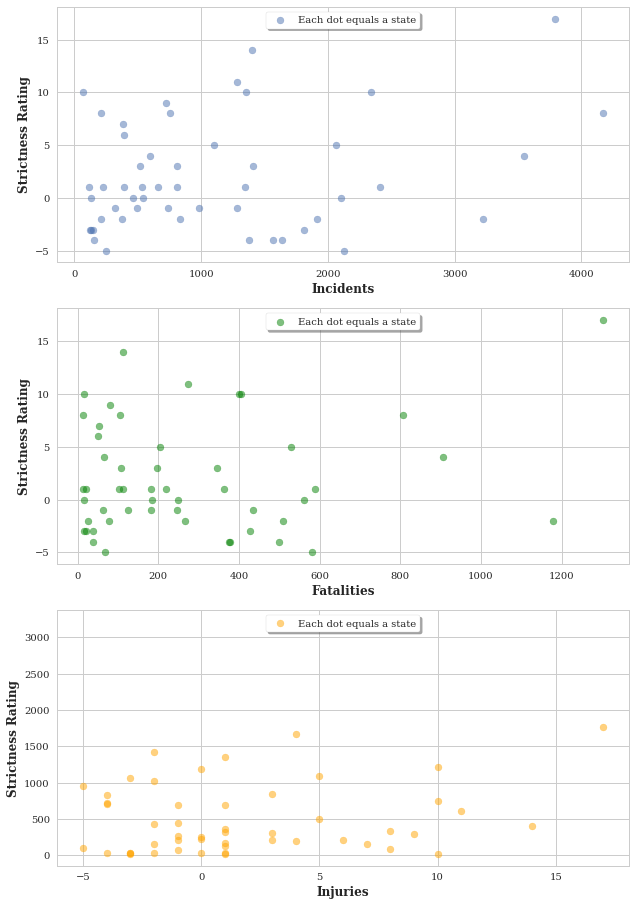

In [25]:
conn = sqlite3.connect('gun_crime_and_state_laws_2.db')
cursor = conn.execute('''
    SELECT 
        State, 
        Average_Incidents_Per_Year, 
        Average_Killed_Per_Year, 
        Average_Injured_Per_Year, 
        Law_Strictness 
    FROM State_Laws_vs_Incidents
''')

rows = cursor.fetchall()

states = list(map(lambda x: x[0], rows))
avg_incidents = list(map(lambda x: x[1], rows))
avg_killeds = list(map(lambda x: x[2], rows))
avg_injureds = list(map(lambda x: x[3], rows))
strictness_ratings = list(map(lambda x: x[4], rows))

conn.close()


plt.figure(figsize=(9, 12.75))

# ========= FIG. 1 ===============

panel_1 = plt.subplot(3, 1, 1)

plt.scatter(
    avg_incidents,
    strictness_ratings,
    alpha=0.5,
    label='Each dot equals a state'
)

plt.xlabel("Incidents")
plt.ylabel("Strictness Rating")
plt.legend(loc=9, frameon=True, shadow=True)

# ========= FIG. 2 ===============

panel_2 = plt.subplot(3, 1, 2)

plt.scatter(
    avg_killeds,
    strictness_ratings,
    c='green',
    alpha=0.5,
    label='Each dot equals a state'
)

plt.xlabel("Fatalities")
plt.ylabel("Strictness Rating")
plt.legend(loc=9, frameon=True, shadow=True)

# ========= FIG. 3 ===============

panel_3 = plt.subplot(3, 1, 3)

plt.scatter(
    strictness_ratings,
    avg_injureds,
    c='orange',
    alpha=0.5,
    label='Each dot equals a state'
)

plt.xlabel("Injuries")
plt.ylabel("Strictness Rating")
plt.legend(loc=9, frameon=True, shadow=True)

# ================================

plt.tight_layout()
plt.show()

### Plotting Linear Regression of Points

[Text(0,0.5,'Strictness of Laws'), Text(0.5,0,'Number of Injuries')]

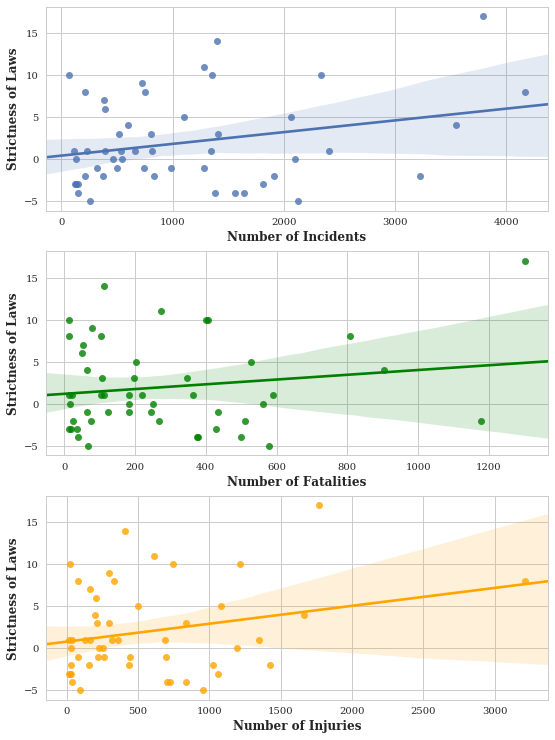

In [26]:
incidents_data = {'avg_incidents': avg_incidents, 'strictness_ratings': strictness_ratings}
incidents_df = pd.DataFrame.from_dict(incidents_data)

fatalies_data = {'avg_fatalities': avg_killeds, 'strictness_ratings': strictness_ratings}
fatalities_df = pd.DataFrame.from_dict(fatalies_data)

injuries_data = {'avg_injureds': avg_injureds, 'strictness_ratings': strictness_ratings}
injuries_df = pd.DataFrame.from_dict(injuries_data)


plt.figure(figsize=(9, 12.75))

# ========= FIG. 1 ===============

panel_1 = plt.subplot(3, 1, 1)

ax = sns.regplot(x="avg_incidents", y="strictness_ratings", data=incidents_df)
ax.set(xlabel='Number of Incidents', ylabel='Strictness of Laws')

# ========= FIG. 2 ===============

panel_2 = plt.subplot(3, 1, 2)

ax = sns.regplot(x="avg_fatalities", y="strictness_ratings", data=fatalities_df, color='green')
ax.set(xlabel='Number of Fatalities', ylabel='Strictness of Laws')

# ========= FIG. 3 ===============

panel_3 = plt.subplot(3, 1, 3)

ax = sns.regplot(x="avg_injureds", y="strictness_ratings", data=injuries_df, color='orange')
ax.set(xlabel='Number of Injuries', ylabel='Strictness of Laws')

### Correlation Coefficients

In [27]:
incidents_corr = incidents_df['avg_incidents'].corr(incidents_df['strictness_ratings'])

fatalities_corr = fatalities_df['avg_fatalities'].corr(incidents_df['strictness_ratings'])

injureds_corr = injuries_df['avg_injureds'].corr(incidents_df['strictness_ratings'])

print('Incidents to Strictness: ' + str(incidents_corr))
print()
print('Fatalities to Strictness: ' + str(fatalities_corr))
print()
print('Injuries to Strictness: ' + str(injureds_corr))

Incidents to Strictness: 0.26927185932514197

Fatalities to Strictness: 0.1585405344810915

Injuries to Strictness: 0.2456525747917981


## CONCLUSION

The above correlation coefficients indicate that there is a weak relationship between the  
two variables of Incidents/Injuries/Fatalities and Law Strictness where as the Strictness increases,  
the Incidents also increase.